In [118]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

In [119]:
f = open('models/waterer.ply')
lines = f.readlines()

In [120]:
from numpy.linalg import inv
def inv_homogenous_matrix(rvec, tvec):
    #https://mathematica.stackexchange.com/questions/106257/how-do-i-get-the-inverse-of-a-homogeneous-transformation-matrix
    rvec_out = inv(rvec)
    tvec_out = np.matmul(-1*rvec_out, tvec)
    return rvec_out, tvec_out

In [186]:
points = []
point_num = int(lines[3].split()[-1])
print(point_num)

sample_rate = 1

zero = [1000.0, 1000.0, 1000.0]
neg_max = 0
for idx, line in enumerate(lines[17:17+point_num]):
    #print(line)
    if idx % sample_rate == 0:
        x, y, z = line.split(' ')[:3]
        x = float(x)/1000
        y = float(y)/1000
        z = float(z)/1000
        # you need to shift all model points cuz zero is not at the bottom of your model
        # gazebo uses model bottom as zero point
        points.append([x, y, z+0.09686700000000001, 1.0])
        if(x**2+y**2+z**2 < zero[0]**2+zero[1]**2+zero[2]**2):
            zero[0] = x
            zero[1] = y
            zero[2] = z
        if neg_max > z:
            neg_max = z
           
print(points)
print(zero)
print(neg_max)


22831
[[-0.006631000000000001, -0.0409674, 0.0202016, 1.0], [-0.0064142, -0.0321502, 0.0020726000000000078, 1.0], [-0.0068868, -0.0409618, 0.016282500000000005, 1.0], [0.010544399999999999, -0.0395709, 0.03166010000000001, 1.0], [-0.008931, 0.055355600000000005, 0.05678880000000001, 1.0], [0.0111942, -0.0173419, 0.003587000000000007, 1.0], [-0.0118758, -0.0400164, 0.019843500000000014, 1.0], [-0.0184269, 0.028065, 0.003980100000000014, 1.0], [-0.030139399999999997, 0.0472818, 0.006504400000000007, 1.0], [-0.0184739, -0.0379132, 0.020554500000000003, 1.0], [-0.020509799999999998, -0.0254599, 0.002798800000000004, 1.0], [-0.0218659, -0.0369389, 0.010901099999999997, 1.0], [0.0484972, 0.0018526, 0.044016500000000014, 1.0], [-0.0450307, -0.0104335, 0.03358860000000001, 1.0], [0.0395038, 0.0361979, 0.03705260000000001, 1.0], [0.0079574, -0.016475300000000002, 0.0036012000000000127, 1.0], [-0.0055872000000000005, -0.038123399999999995, 0.11531000000000001, 1.0], [0.0449613, -0.0119594, 0.029

In [187]:
points = np.array(points)
print(points[:, 2])

[0.0202016 0.0020726 0.0162825 ... 0.0335682 0.0036553 0.0508755]


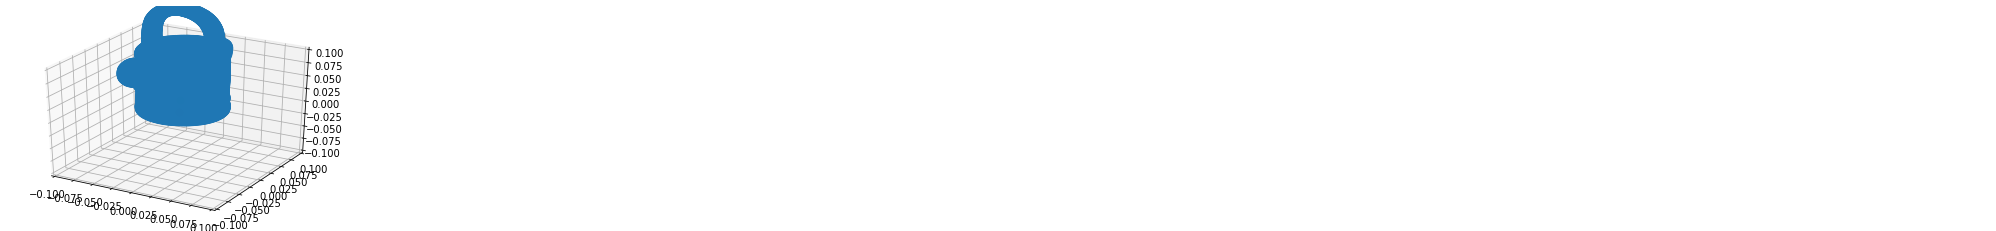

In [188]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.scatter(0, 0, 0, c = 'red', s = 50)
ax.scatter(0.000559, 0.001484, 0.022542000000000003, c = 'green', s = 50)
ax.set_xlim3d(-0.1, 0.1)
ax.set_ylim3d(-0.1, 0.1)
ax.set_zlim3d(-0.1, 0.1)
plt.show()

In [189]:
'''
test data information

camera rotation only (model pos = (0, 0, 0, 0, 0, 0))
   x,    y,    z,  roll, pitch,  yaw, img
   1,  0.5,  1.0,   0.0,   0.5, -2.5, 0002.png
 0.5,  0.5,  1.0,   0.0,   0.8, -2.5, 0003.png
-0.5,  0.5,  0.5,   0.0,   0.4, -0.9, 0004.png
 
'''

test_data = [[   1,  0.5,  1.0,   0.0,   0.5, -2.5, "rgb/0002.png"],
             [ 0.5,  0.5,  1.0,   0.0,   0.8, -2.5, "rgb/0003.png"],
             [-0.5,  0.5,  0.5,   0.0,   0.4, -0.9, "rgb/0004.png"]]

In [190]:
# calculate camera rvec, tvec

data_idx = 2

roll, pitch, yaw = test_data[data_idx][3:6]

Ry = [[np.cos(pitch), 0, np.sin(pitch)],
      [0, 1, 0],
      [-np.sin(pitch), 0, np.cos(pitch)]]
Rz = [[np.cos(yaw), -np.sin(yaw), 0],
      [np.sin(yaw), np.cos(yaw), 0],
      [0, 0, 1]]

Rc = [[np.cos(0.5*math.pi), 0, np.sin(0.5*math.pi)],
      [0, 1, 0],
      [-np.sin(0.5*math.pi), 0, np.cos(0.5*math.pi)]]

camera_rvec = np.matmul(np.array(Rz), np.array(Ry)) #seem to be closer than Ry * Rz
camera_tvec = np.array(test_data[data_idx][0:3])

print(camera_rvec, camera_tvec)
camera_rvec, camera_tvec = inv_homogenous_matrix(camera_rvec, camera_tvec)
print(camera_rvec, camera_tvec)
extrinsic = np.append(camera_rvec, camera_tvec.reshape((3, 1)), axis=1)
#print(extrinsic)

[[ 0.5725407   0.78332691  0.24206632]
 [-0.72149186  0.62160997 -0.30504187]
 [-0.38941834  0.          0.92106099]] [-0.5  0.5  0.5]
[[ 5.72540695e-01 -7.21491862e-01 -3.89418342e-01]
 [ 7.83326910e-01  6.21609968e-01 -2.00254219e-17]
 [ 2.42066323e-01 -3.05041867e-01  9.21060994e-01]] [ 0.84172545  0.08085847 -0.1869764 ]


In [191]:
points_cam_frame = np.matmul(extrinsic, points.transpose())

rot_to_cam = np.array([[ 0, -1, 0],
                       [ 0,  0, -1],
                       [ 1,  0, 0]])
points_cam_frame = np.matmul(rot_to_cam, points_cam_frame)

print(points_cam_frame.transpose())

[[-0.05019849  0.15747787  0.8596197 ]
 [-0.05584917  0.17681292  0.86044206]
 [-0.05000159  0.16115122  0.86099538]
 ...
 [-0.09627273  0.17668599  0.7798637 ]
 [-0.07485538  0.17801668  0.85353061]
 [-0.13227733  0.15815319  0.7792539 ]]


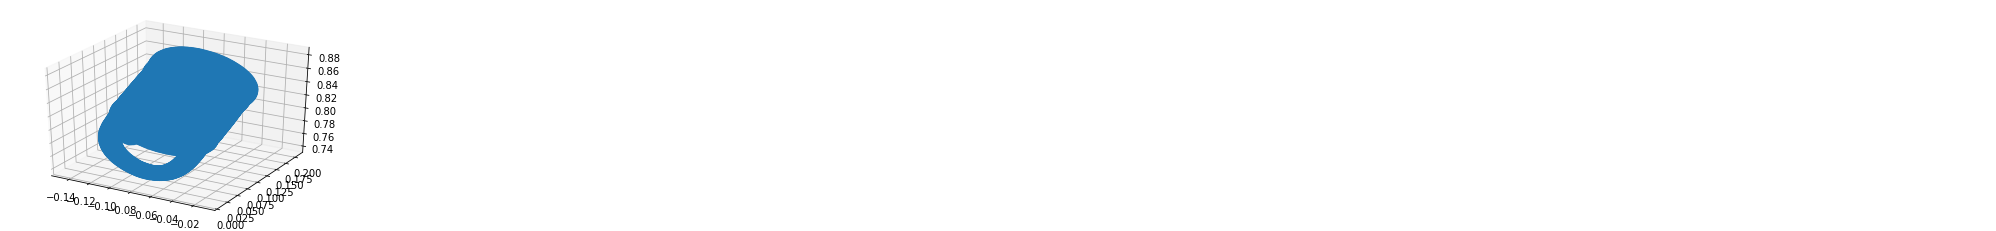

In [192]:
points_cam = points_cam_frame.transpose()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_cam[:, 0], points_cam[:, 1], points_cam[:, 2])
#ax.set_xlim3d(-101, 101)
#ax.set_ylim3d(-102, 102)
#ax.set_zlim3d(-103, 103)
plt.show()

In [193]:
intrinsic = [572.411400033838, 0.0, 320.0, 0.0, 572.4114000338382, 240, 0.0, 0.0, 1.0]
intrinsic = np.array(intrinsic).reshape((3, 3))
print(intrinsic)

[[572.41140003   0.         320.        ]
 [  0.         572.41140003 240.        ]
 [  0.           0.           1.        ]]


In [194]:
pixel_pos = np.matmul(intrinsic, points_cam_frame)
print(pixel_pos.transpose())

[[246.34411997 296.45085475   0.8596197 ]
 [243.37275688 307.71582268   0.86044206]
 [246.89703975 298.88368884   0.86099538]
 ...
 [194.44877459 288.30436113   0.7798637 ]
 [230.28172363 306.74612623   0.85353061]
 [173.64419924 277.54962716   0.7792539 ]]


In [195]:
img = cv2.imread(test_data[data_idx][6])
print(img.shape)

(480, 640, 3)


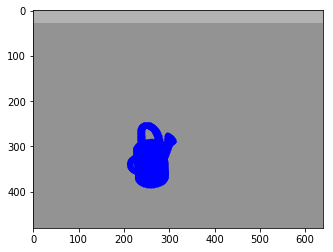

In [196]:
plt.imshow(img)
for row in pixel_pos.transpose():
    row[0] /= row[2]
    row[1] /= row[2]
    row[2] /= row[2]
    #print(row)
    if abs(row[0]) < 1000:
        #pass
        plt.scatter([row[0]], [row[1]], s = 0.1, c = 'blue')
plt.show()